#Convolution + Dense Model - Binary Dataset
# Deep Learning Medical Image Analysis
A dense neural network model trained using a simple pathology image dataset.

## Python Imports
This section will load the necessary python packages to the instance.

In [ ]:
from tensorflow import keras
keras.__version__

'2.12.0'

In [ ]:
# Built-in Imports
import random

In [ ]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader (PneumoniaMNIST)
This section will download the selected [MedMNIST](https://medmnist.github.io/) dataset as a NumPy array object to your Google Colab instance.

### Here we are using the PneumoniaMNIST dataset

In [ ]:
DATA_NAME = "PneumoniaMNIST"

In [ ]:
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2023-04-11 11:30:04--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22841 (22K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  22.31K  --.-KB/s    in 0.001s  

2023-04-11 11:30:04 (30.5 MB/s) - ‘info.py’ saved [22841/22841]



In [ ]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

4170669/4170669 [==============================] - 3s 1us/step


In [ ]:
# Loads the downloaded NumPy object.
dataset = np.load(file_path)

# ImageDataGenerator requires 4 dimensions in the array. But here we have only 3 dimensions in the dataset as RGB channel is not present in the data.
# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
train_y = dataset["train_labels"]
train_x = train_x[..., np.newaxis]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
val_y = dataset["val_labels"]
val_x = val_x[..., np.newaxis]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
test_y = dataset["test_labels"]
test_x = test_x[..., np.newaxis]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [ ]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset.
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


884: pneumonia


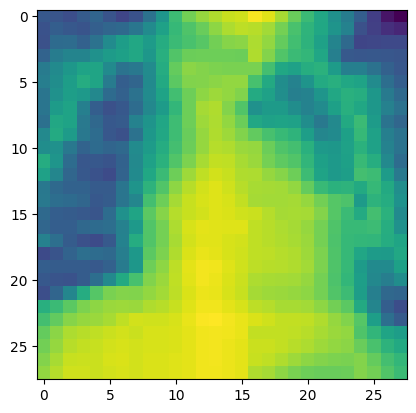

In [ ]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed. Following are the data augmentations we are applying-:
*   horizontal_flip - Randomly flip inputs horizontally.
*   rotation_range - Degree range for random rotations.
*   width_shift_range - Fraction of total width shift
*   height_shift_range - Fraction of total height shift
*   shear_range - Shear Intensity (Shear angle in counter-clockwise direction in degrees)
*   zoom_range - Percentage of zoom-in and zoom-out
*   fill_mode - Points outside the boundaries of the input are filled according to the given mode:

These augmentations are applied keeping in mind to keep the augmented images similar to the original as the augmented images would have the same label class as the original images. Applying too much augmentation may change the images to a large extent and would not make sense with the label classess.










In [ ]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(rotation_range=40,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

In [ ]:
# Here we fit the ImageDataGenerator to the dataset
data_generator.fit(np.append(train_x, val_x, 0))

1704: pneumonia


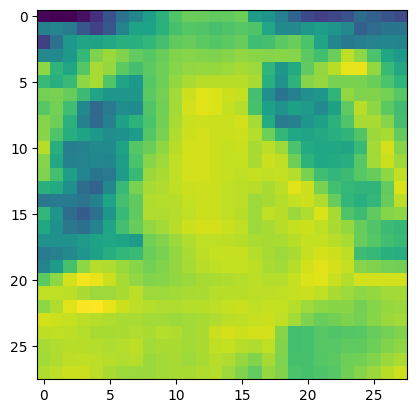

In [ ]:
# Displays a random image from training dataset after augmentation.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Model Definition
In this section we will define the neural network arcitecture. We will create a network with a combination of convolution and dense layers. Two convolution layers with two max pooling layers are enough. This serves both to augment the capacity of the network, and to further reduce the size of the
feature maps, so that they aren't overly large when we reach the **Flatten** layer. The depth of the feature maps is progressively increasing in the network (from 32 to 64) because it allows the network to learn more complex and abstract features. The early layers of the network learn simple features like edges and corners, while the later layers learn more complex features like shapes and textures. This makes it easier for the network to discriminate between different classes of objects.

We than add a flattening layer to flatten the output received from convolution layers and max pooling as dense layers only recieve 1D arrays as their inputs.

We are adding two dense layers to the network, one of which will be the hidden layer and the other one will be the output layer. This gives us a combination of convolution and dense layers so that our feature maps are reduced to essential features and we also have a certain depth of dense networks to enhance the training of the data.

We will also add a dropout layer with rate=0.5 after the flattening operation which acts as a regularization method and helps to make the network more robust.

The dense layers have **relu** as their activation function. The output layer is a **softmax** activation function as it outputs the probability of each data point to belong to one of the class labels.

We are using **binary crossentropy** as our loss function as this is ideal function for binary classification problems.

We will keep **SGD** as our optimizer in all our models so that we can compare all the models.

In [ ]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutoonal layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

#Dropout layer
dropout1 = layers.Dropout(0.5)(flatten)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
dense1 = layers.Dense(32, activation='relu')(dropout1)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=len(np.unique(train_y)), activation="softmax")(dense1)

# Initilises the defined model and prints summary of the model.
model = Model(inputs=input, outputs=output, name="Model")
print(model.summary())


Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0     

## Model Training
This is where we define the training options and then train the model.


In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy", "AUC", "Precision", "Recall"])

Let us see the model performance with and without the ImageDataGenerator to observe its effect.

# Model fit

In [ ]:
history = model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
73/73 [==============================] - 15s 32ms/step - loss: 1.3150 - accuracy: 0.6982 - auc: 0.7173 - precision: 0.6982 - recall: 0.6982 - val_loss: 0.5329 - val_accuracy: 0.7405 - val_auc: 0.8436 - val_precision: 0.7405 - val_recall: 0.7405
Epoch 2/10
73/73 [==============================] - 2s 24ms/step - loss: 0.5582 - accuracy: 0.7545 - auc: 0.8173 - precision: 0.7545 - recall: 0.7545 - val_loss: 0.4892 - val_accuracy: 0.7634 - val_auc: 0.8683 - val_precision: 0.7634 - val_recall: 0.7634
Epoch 3/10
73/73 [==============================] - 2s 24ms/step - loss: 0.5170 - accuracy: 0.7734 - auc: 0.8451 - precision: 0.7734 - recall: 0.7734 - val_loss: 0.4508 - val_accuracy: 0.8206 - val_auc: 0.9010 - val_precision: 0.8206 - val_recall: 0.8206
Epoch 4/10
73/73 [==============================] - 2s 30ms/step - loss: 0.4899 - accuracy: 0.7867 - auc: 0.8631 - precision: 0.7867 - recall: 0.7867 - val_loss: 0.4859 - val_accuracy: 0.7767 - val_auc: 0.8839 - val_precision: 0.7767 

## Plot Learning Curves
This is where we visualise the training of the model.

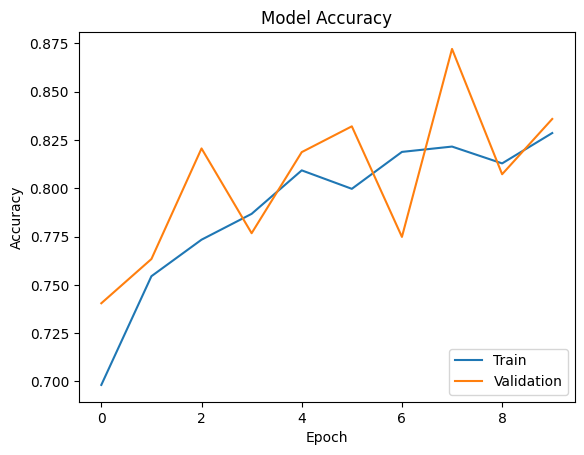

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

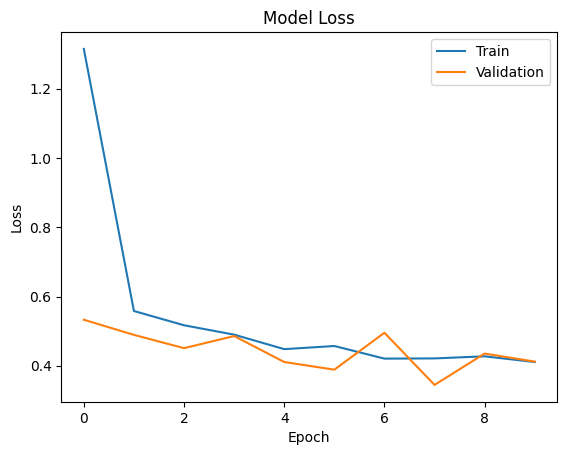

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(data_generator.flow(test_x, to_categorical(test_y)))

20/20 [==============================] - 0s 15ms/step - loss: 0.5402 - accuracy: 0.7228 - auc: 0.8348 - precision: 0.7228 - recall: 0.7228


As we can see in the plots, validation accuracy not improving after a certain number of epochs. so we will reduce the number of epochs.

In [ ]:
final_model = Model(inputs=input, outputs=output, name="Model")
final_model.summary()

Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0     

In [ ]:
# Defines the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 8
LEARNING_RATE = 0.001

In [ ]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
final_model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy", "AUC", "Precision", "Recall"])

In [ ]:
history = final_model.fit(data_generator.flow(train_x, to_categorical(train_y), batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, to_categorical(val_y), batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/8
73/73 [==============================] - 3s 28ms/step - loss: 0.3904 - accuracy: 0.8326 - auc: 0.9129 - precision: 0.8326 - recall: 0.8326 - val_loss: 0.3464 - val_accuracy: 0.8378 - val_auc: 0.9275 - val_precision: 0.8378 - val_recall: 0.8378
Epoch 2/8
73/73 [==============================] - 2s 24ms/step - loss: 0.4088 - accuracy: 0.8203 - auc: 0.9023 - precision: 0.8203 - recall: 0.8203 - val_loss: 0.3532 - val_accuracy: 0.8492 - val_auc: 0.9269 - val_precision: 0.8492 - val_recall: 0.8492
Epoch 3/8
73/73 [==============================] - 2s 24ms/step - loss: 0.3766 - accuracy: 0.8381 - auc: 0.9181 - precision: 0.8381 - recall: 0.8381 - val_loss: 0.4762 - val_accuracy: 0.7996 - val_auc: 0.8850 - val_precision: 0.7996 - val_recall: 0.7996
Epoch 4/8
73/73 [==============================] - 2s 24ms/step - loss: 0.3799 - accuracy: 0.8435 - auc: 0.9161 - precision: 0.8435 - recall: 0.8435 - val_loss: 0.3773 - val_accuracy: 0.8378 - val_auc: 0.9155 - val_precision: 0.8378 - val

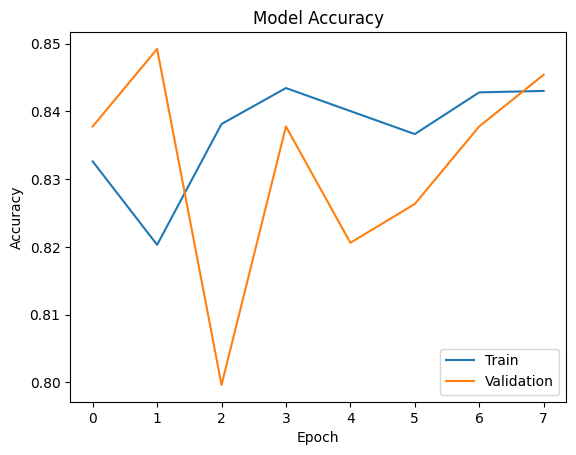

In [ ]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

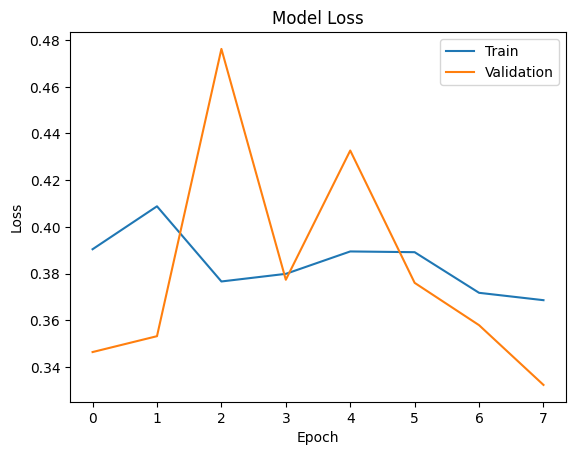

In [ ]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

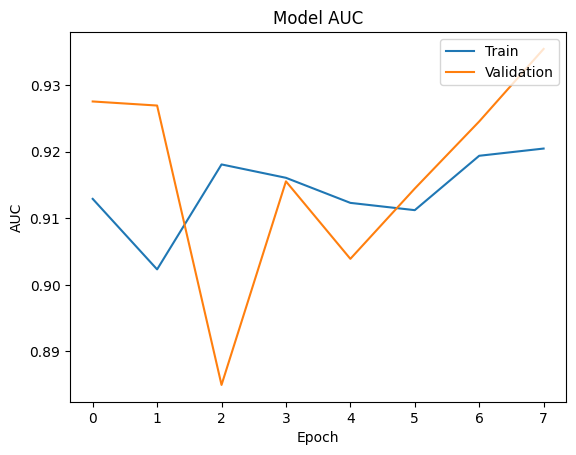

In [ ]:
# Plots the training and validation AUC over the number of epochs.
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

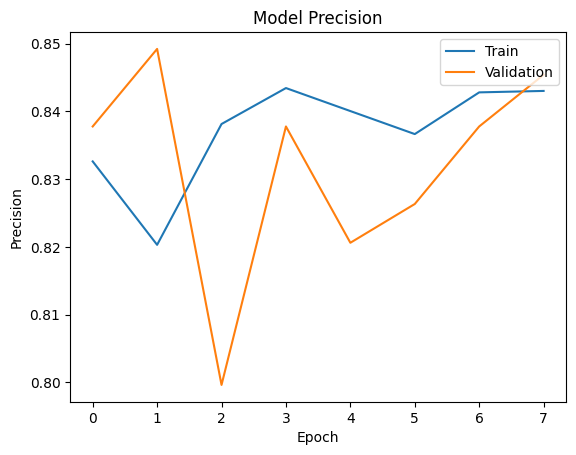

In [ ]:
# Plots the training and validation precision over the number of epochs.
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

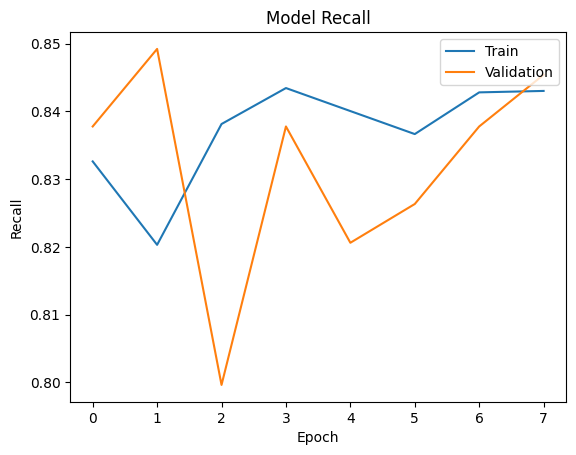

In [ ]:
# Plots the training and validation recall over the number of epochs.
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_loss, test_acc, test_auc, test_precision, test_recall = final_model.evaluate(data_generator.flow(test_x, to_categorical(test_y)))

20/20 [==============================] - 0s 12ms/step - loss: 0.4971 - accuracy: 0.7772 - auc: 0.8630 - precision: 0.7772 - recall: 0.7772


In [ ]:
print("PneumoniaMNIST\n" + "Loss - " + str(test_loss) + "\n" + "Accuracy - " + str(test_acc) + "\n" + "AUC - " + str(test_auc) + "\n" + "Precision - " + str(test_precision) + "\n" + "Recall - " + str(test_recall))

PneumoniaMNIST
Loss - 0.4971214830875397
Accuracy - 0.7772436141967773
AUC - 0.8629885315895081
Precision - 0.7772436141967773
Recall - 0.7772436141967773
